# Import

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import tight_subplot as ts
import nonmax as nm
import numpy as np
import scipy as sp
import math

# Problem 1: Image Pyramids

Load the provided image “texture.jpeg” and convert it to grayscale. Write code for a Gaussian and Laplacian pyramid of 5 levels (use for loops). At each level, the resolution should be reduced by a factor of 2. Show your pyramids and include the code in your submission.

In [117]:
# Convert to gray scale
texture_img = cv2.imread('texture.jpeg')
# texture_img_yuv = cv2.cvtColor(texture_img, cv2.COLOR_BGR2YUV)
# texture_y, texture_u, texture_v = cv2.split(texture_img_yuv)
# # display the Y component in notebook
# plt.imshow(texture_y, cmap='gray')
# X, Y, Z = texture_img.shape
# print(X, Y)
# print(texture_y.shape)
texture_img_gray = np.dot(texture_img[...,:3], [0.2989, 0.587, 0.114])
Y, X = texture_img_gray.shape
print(texture_img_gray.shape)

(483, 743)


## Part 1: 
Display a Gaussian and Laplacian pyramid of level 5 (write your code). It should be formatted
similarly to Figure 1 above. You may find the included “tight_subplot.py” helpful for making plots.

In [108]:
def get_filter(kernel_size, sigma):
    kernel = cv2.getGaussianKernel(kernel_size, sigma)
    image_filter = np.dot(kernel, kernel.T)
    return image_filter

In [109]:
def getGaussianPyramid(image, image_filter, iterations):
    gaussian_images = []
    original_image = image
    for i in range(iterations):
        original_image = cv2.filter2D(original_image, -1, image_filter)
        gaussian_images.append(original_image)
    return gaussian_images

In [110]:
def getLaplacianPyramid(image, image_filter, iterations):
    laplacian_images = []
    original_image = image
    for i in range(iterations):
        blurred_image = cv2.filter2D(original_image, -1, image_filter)
        # compute residual
        residual = np.subtract(original_image, blurred_image)
        laplacian_images.append(residual)
        
        original_image = blurred_image[::2, ::2]
    return laplacian_images

In [114]:
def resizeImage(image, width, height):

    # Create a white image with the desired size
    resized_image = np.ones((width, height), dtype=np.uint8) * 255
    print(resized_image.shape)

    # Get the dimensions of the original image
    original_height, original_width = image.shape

    # Calculate the position to place the original image in the new image (top-left corner)
    x_offset = 0
    y_offset = 0

    # Place the original image onto the new image
    resized_image[y_offset:y_offset + original_height, x_offset:x_offset + original_width] = image

    return resized_image


In [115]:
gaussian_pyramid, laplacian_pyramid = getGaussianPyramid(texture_img_gray, get_filter(3, 1), 5), getLaplacianPyramid(texture_img_gray, get_filter(3, 1), 5)

In [116]:
resized_gaussian_pyramid = [resizeImage(image, X, Y) for image in gaussian_pyramid]
resized_laplacian_pyramid = [resizeImage(image, X, Y) for image in laplacian_pyramid]

(743, 483)


ValueError: could not broadcast input array from shape (483,743) into shape (483,483)

In [101]:
print(laplacian_pyramid[0])

[[ 12.05781334  -6.15273569  -0.68553747 ...   2.16594652  -1.76807629
   -8.41612806]
 [ 15.01950032  -3.33721747   1.13126174 ...   0.77340071   0.19893512
   -3.73913113]
 [ 11.63355993  -3.43870674   0.18530909 ...   2.19914271   1.69978321
   -2.26062278]
 ...
 [ 21.16482769  -4.56269885   4.61540294 ...  -8.57575487  -5.20012352
   14.4203619 ]
 [ 13.30419038  -5.55593034   0.25346348 ...  -6.04347749  -4.86944808
   14.79822546]
 [ -0.14212534 -13.83397648 -11.92817888 ...  -5.1685875   -3.97221835
   16.69013077]]


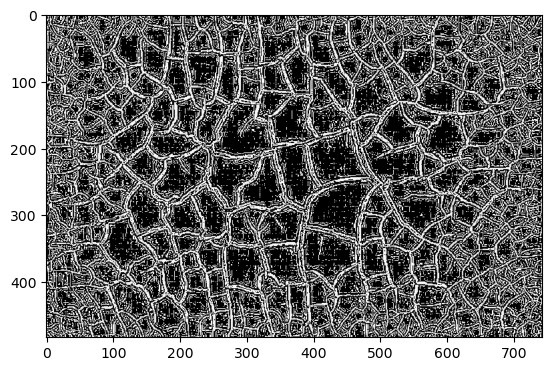

In [93]:
plt.imshow(resized_laplacian_pyramid[0], cmap='gray')

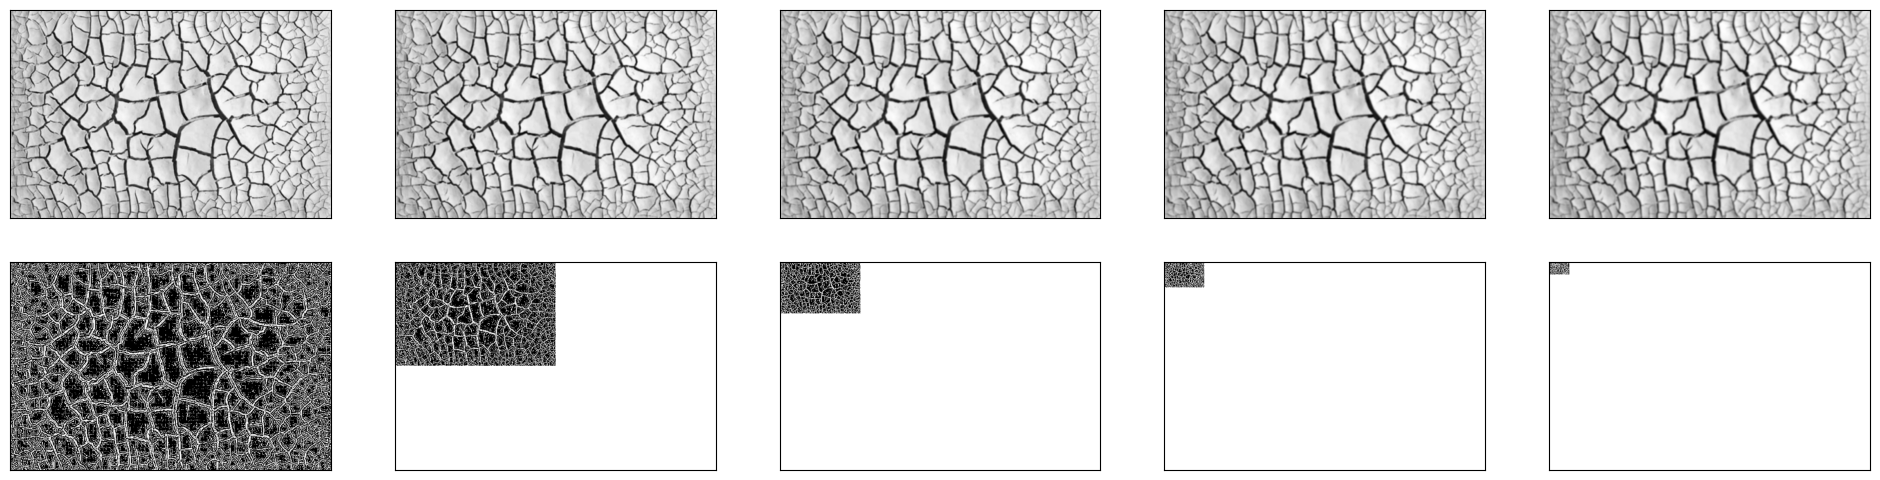

In [83]:
ts.tight_subplot_2x5(resized_gaussian_pyramid, resized_laplacian_pyramid)

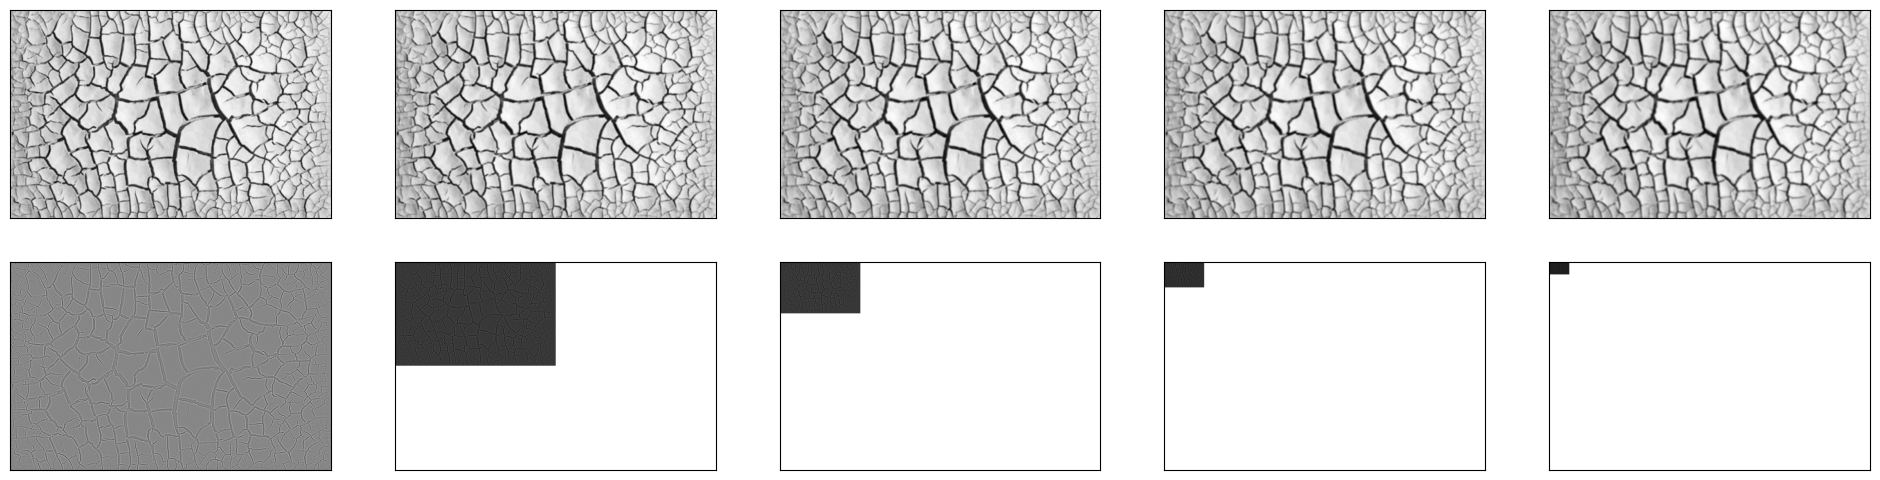

In [57]:
# Display Pyramid
padded_gaussian_images = []
padded_laplacian_images = []
for i in range(5):
    gaussian_image = gaussian_pyramid[i]
    laplacian_image = laplacian_pyramid[i]

    pad_right = Y - gaussian_image.shape[1]
    pad_bottom = X - gaussian_image.shape[0]
    padded_gaussian_image = cv2.copyMakeBorder(gaussian_image, 0, pad_bottom, 0, pad_right, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    padded_gaussian_images.append(padded_gaussian_image)

    pad_right = Y - laplacian_image.shape[1]
    pad_bottom = X - laplacian_image.shape[0]
    padded_laplacian_image = cv2.copyMakeBorder(laplacian_image, 0, pad_bottom, 0, pad_right, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    padded_laplacian_images.append(padded_laplacian_image)

ts.tight_subplot_2x5(padded_gaussian_images, padded_laplacian_images)


## Part 2: 
Display the FFT amplitudes of your Gaussian/Laplacian pyramids. Appropriate display ranges ("vmin", "vmax") should be chosen so that frequencies in different pyramid levels are clearly visible. Explain what the Laplacian and Gaussian pyramids are doing in terms of frequency.

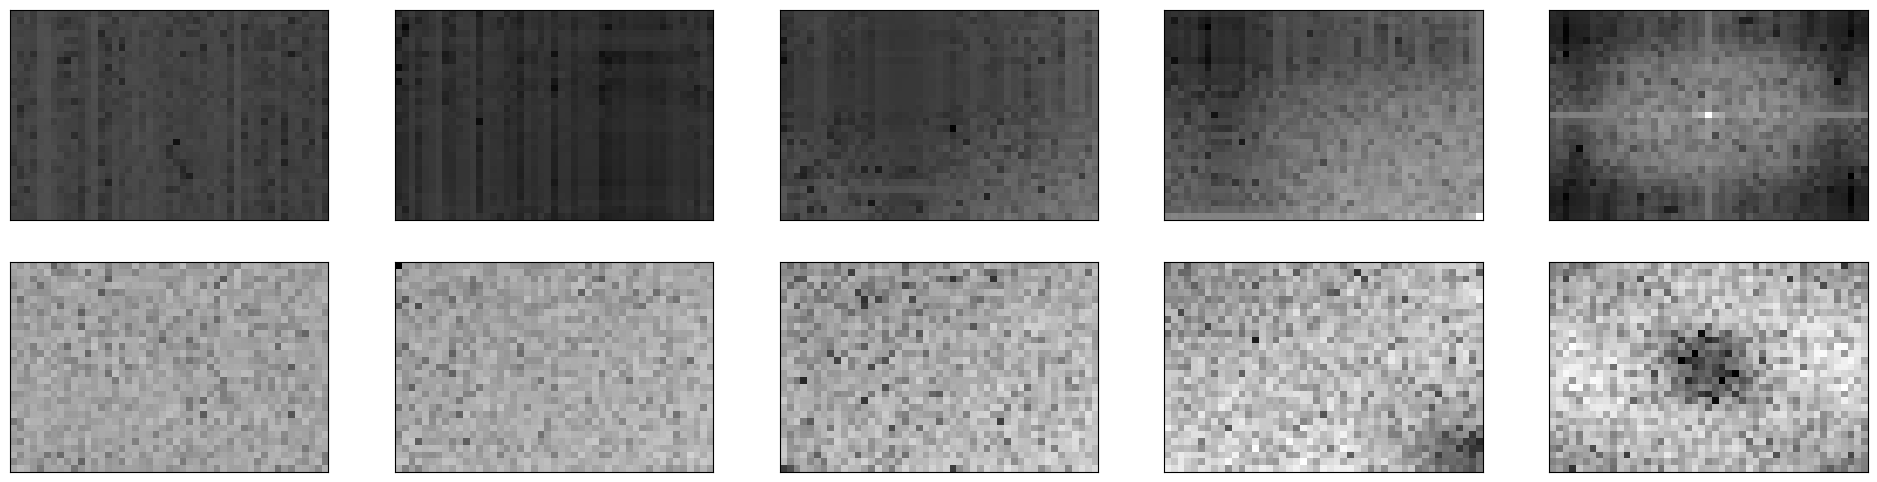

In [60]:
fft_gaussian_images = []
fft_laplacian_images = []

for i in range(5):
    fft_gaussian_image = np.fft.fft2(gaussian_images[i])
    fft_shift_gaussian_image = np.fft.fftshift(fft_gaussian_image)
    magnitude_spectrum_gaussian = 20 * np.log(np.abs(fft_shift_gaussian_image))
    fft_gaussian_images.append(magnitude_spectrum_gaussian)

    fft_laplacian_image = np.fft.fft2(laplacian_images[i])
    fft_shift_laplacian_image = np.fft.fftshift(fft_laplacian_image)
    magnitude_spectrum_laplacian = 20 * np.log(np.abs(fft_shift_laplacian_image))
    fft_laplacian_images.append(magnitude_spectrum_laplacian)

ts.tight_subplot_2x5(fft_gaussian_images, fft_laplacian_images)


# Problem 2: Edge Detection

In this problem, we will detect the edges of the provided image "plane.jpg".

## Part 1: Build a simple gradient-based edge detector that includes the following functions
Complete two functions below, and visualize your detected edges.


1. `def gradientMagnitude(im: np.ndarray, sigma: float): return mag: np.ndarray, theta: np.ndarray`

This function should take an RGB image as input, smooth the image with a Gaussian filter (std=sigma),
compute the x and y gradient values of the smoothed image, and output image maps of the gradient
magnitude and orientation at each pixel. You can compute the gradient magnitude of an RGB image by
taking the L2-norm of the R, G, and B gradients. The orientation can be computed from the channel
corresponding to the largest gradient magnitude. The overall gradient magnitude is the L2-norm of the x
and y gradients. mag and theta should be the same size as im.

2. `def edgeGradient(im: np.ndarray): return bmap: np.ndarray`

This function should use gradientMagnitude to compute a soft boundary map and then perform
non-maxima suppression. You could use the provided nonmax.py.

Useful functions include: cv2.getGaussianKernel, cv2.filter2D, cv2.spatialGradient, np.take_along_axis

In [107]:
def gradientMagnitude(im: np.ndarray, sigma: float):
    # return mag: np.ndarray, theta: np.ndarray
    # img is a RGB image
    # compute the gradients x and y gradients for each R, G, and B

    # smooth image first
    im = cv2.GaussianBlur(im, (3, 3), sigma)
    
    red_channel = im[:, :, 0]
    green_channel = im[:, :, 1]
    blue_channel = im[:, :, 2]

    # sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -11]])
    # sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    # red_x_gradient = cv2.filter2D(red_channel, -1, sobel_x)
    # red_y_gradient = cv2.filter2D(red_channel, -1, sobel_y)

    # green_x_gradient = cv2.filter2D(green_channel, -1, sobel_x)
    # green_y_gradient = cv2.filter2D(green_channel, -1, sobel_y)

    # blue_x_gradient = cv2.filter2D(blue_channel, -1, sobel_x)
    # blue_y_gradient = cv2.filter2D(blue_channel, -1, sobel_y)

    red_x_gradient, red_y_gradient = cv2.spatialGradient(red_channel, dx=1, dy=1)

    green_x_gradient, green_y_gradient = cv2.spatialGradient(green_channel, dx=1, dy=1)

    blue_x_gradient, blue_y_gradient = cv2.spatialGradient(blue_channel, dx=1, dy=1)

    # compute the gradient magnitude and direction
    magnitude = np.sqrt(red_x_gradient**2 + red_y_gradient**2 + green_x_gradient**2 + green_y_gradient**2 + blue_x_gradient**2 + blue_y_gradient**2)
    theta = np.arctan2(red_y_gradient + green_y_gradient + blue_y_gradient, red_x_gradient + green_x_gradient + blue_x_gradient)

    return magnitude, theta

In [108]:
def edgeGradient(im: np.ndarray):
    # return bmap: np.ndarray
    magnitude, theta = gradientMagnitude(im, 1)
    non_maxima_suppressed_edge = nm.non_max_suppression(magnitude, theta)
    return non_maxima_suppressed_edge

(321, 481, 3)


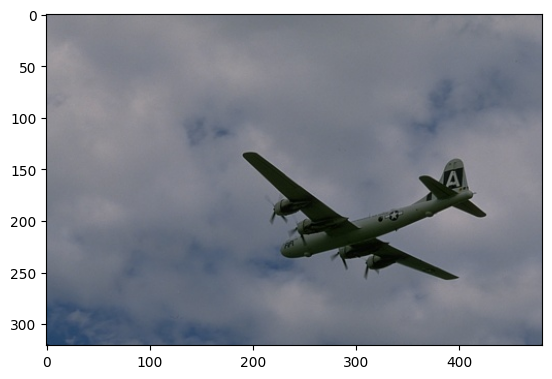

In [109]:
# Test Code
img = Image.open('plane.jpg')
img = np.array(img)
print(img.shape)
plt.imshow(img)

C:\Users\patel\AppData\Local\Temp\ipykernel_19660\93332948.py:32: RuntimeWarning: invalid value encountered in sqrt
  magnitude = np.sqrt(red_x_gradient**2 + red_y_gradient**2 + green_x_gradient**2 + green_y_gradient**2 + blue_x_gradient**2 + blue_y_gradient**2)


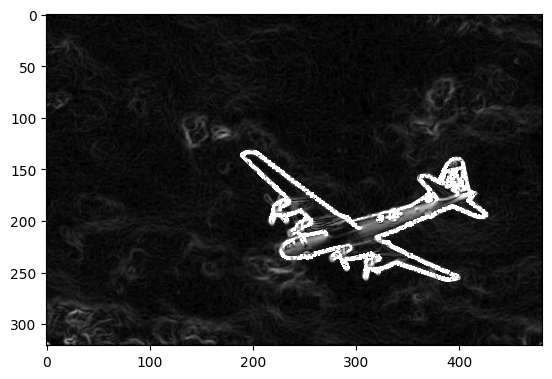

In [110]:
magnitude, theta = gradientMagnitude(img, 1)
plt.imshow(magnitude, cmap='gray')

C:\Users\patel\AppData\Local\Temp\ipykernel_19660\93332948.py:32: RuntimeWarning: invalid value encountered in sqrt
  magnitude = np.sqrt(red_x_gradient**2 + red_y_gradient**2 + green_x_gradient**2 + green_y_gradient**2 + blue_x_gradient**2 + blue_y_gradient**2)


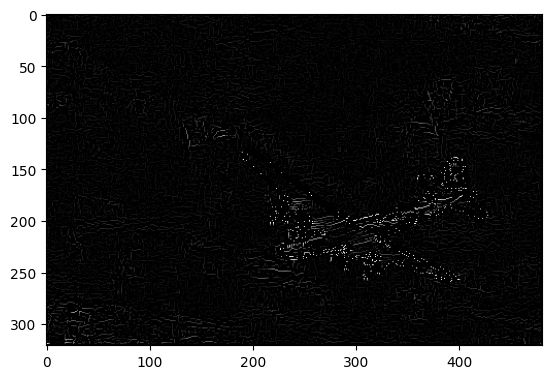

In [111]:
thin_edge = edgeGradient(img)
plt.imshow(thin_edge, cmap='gray')

## Part 2: Try to improve your results using a set of oriented filters, rather than the simple derivative of Gaussian approach above, including the following functions

Complete two functions below, and visualize both filters you used and your detected edges.

1. `def orientedFilterMagnitude(im: np.ndarray): return mag: np.ndarray, theta: np.ndarray`

Computes the boundary magnitude and orientation using a set of oriented filters, such as elongated
Gaussian derivative filters. Explain your choice of filters. Use at least four orientations. One way to combine filter responses is to compute a boundary score for each filter (simply by filtering with it) and then use the max and argmax over filter responses to compute the magnitude and orientation for each pixel.

2. `def edgeOrientedFilters(im: np.ndarray): return bmap: np.ndarray`

Similar to Problem 2.1, this should call orientedFilterMagnitude, perform the non-maxima suppression, and output the final soft edge map.

Useful functions include: np.mgrid, scipy.stats.multivariate_normal

In [163]:
def orientedFilterMagnitude(im: np.ndarray):
    # return mag: np.ndarray, theta: np.ndarray
    # orientations would be 0, 45, 90, 135 degrees

    sigma = 1
    im = cv2.GaussianBlur(im, (3, 3), sigma)
    red_channel = im[:, :, 0]
    green_channel = im[:, :, 1]
    blue_channel = im[:, :, 2]

    orientations = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    red_mags = []
    blue_mags = []
    green_mags = []
    avg_mags = []
    total_mags = []
    
    for orientation in orientations:
        # a kernel size of 3x3 was assumed
        x,y = np.mgrid[-1:2, -1:2]

        x_rot = x * np.cos(orientation) - y * np.sin(orientation)
        y_rot = x * np.sin(orientation) + y * np.cos(orientation)

        kernel = np.zeros((3, 3))

        mvn = sp.stats.multivariate_normal([0, 0], [[1**2, 0], [0, 1**2]])
        kernel = -x_rot * mvn.pdf(np.stack([x_rot, y_rot], axis=-1))

        kernel /= np.sum(np.abs(kernel))

        # apply the filter
        red_mags.append(cv2.filter2D(red_channel, -1, kernel))
        green_mags.append(cv2.filter2D(green_channel, -1, kernel))
        blue_mags.append(cv2.filter2D(blue_channel, -1, kernel))
        avg_mags.append((red_mags[-1] + green_mags[-1] + blue_mags[-1])/3)

    # now we have the average magnitude for each orientation
    # we can compute the magnitude and direction
    def polar_to_cartesian(length, direction):
        x = length * math.cos(direction)
        y = length * math.sin(direction)
        return x, y
    
    vectors = zip(avg_mags, orientations)

    for i in range(len(orientations)):
        resultant_x = sum(polar_to_cartesian(length, direction)[0] for length, direction in vectors)
        resultant_y = sum(polar_to_cartesian(length, direction)[1] for length, direction in vectors)

        # Calculate magnitude of the resultant vector
        magnitude = math.sqrt(resultant_x**2 + resultant_y**2)

        # Calculate direction of the resultant vector (in radians)
        direction = math.atan2(resultant_y, resultant_x)
    return magnitude, direction
        

In [165]:
# Test Code
img = Image.open('plane.jpg')
img = np.array(img)
mag, dir = orientedFilterMagnitude(img)
plt.imshow(mag, cmap='gray')

TypeError: only length-1 arrays can be converted to Python scalars